# Лабораторная работа №5

*Вариант задания:* 

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

df = pd.read_csv("../../datasets/nuforc_reports.csv")
df = df.iloc[:1000].dropna()
print(df.columns)

Index(['summary', 'city', 'state', 'date_time', 'shape', 'duration', 'stats',
       'report_link', 'text', 'posted', 'city_latitude', 'city_longitude'],
      dtype='object')


In [28]:
df.head()

summary        city state  \
0  Viewed some red lights in the sky appearing to...     Visalia    CA   
1  Look like 1 or 3 crafts from North traveling s...  Cincinnati    OH   
3  One red light moving switly west to east, beco...   Knoxville    TN   
5  I'm familiar with all the fakery and UFO sight...   Fullerton    CA   
6  I was driving up lakes mead towards the lake a...   Las Vegas    NV   

             date_time     shape       duration  \
0  2021-12-15T21:45:00     light      2 minutes   
1  2021-12-16T09:45:00  triangle     14 seconds   
3  2021-12-10T19:30:00  triangle  20-30 seconds   
5  2020-07-07T23:00:00   unknown      2 minutes   
6  2020-04-23T03:00:00      oval     10 minutes   

                                               stats  \
0  Occurred : 12/15/2021 21:45  (Entered as : 12/...   
1  Occurred : 12/16/2021 09:45  (Entered as : 12/...   
3  Occurred : 12/10/2021 19:30  (Entered as : 12/...   
5  Occurred : 7/7/2020 23:00  (Entered as : 07/07...   
6  Occurred : 4/23/2020 03:00  (Entered as : 4/23...   

                                         report_link  \
0  http://www.nuforc.org/webreports/165/S165881.html   
1  http://www.nuforc.org/webreports/165/S165888.html   
3  http://www.nuforc.org/webreports/165/S165825.html   
5  http://www.nuforc.org/webreports/157/S157444.html   
6  http://www.nuforc.org/webreports/155/S155608.html   

                                                text               posted  \
0  Viewed some red lights in the sky appearing to...  2021-12-19T00:00:00   
1  Look like 1 or 3 crafts from North traveling s...  2021-12-19T00:00:00   
3  One red light moving switly west to east, beco...  2021-12-19T00:00:00   
5  I'm familiar with all the fakery and UFO sight...  2020-07-09T00:00:00   
6  I was driving up lakes mead towards the lake a...  2020-05-01T00:00:00   

   city_latitude  city_longitude  
0      36.356650     -119.347937  
1      39.174503      -84.481363  
3      35.961561      -83.980115  
5      33.877422     -117.924978  
6      36.141246     -115.186592

In [29]:
df.describe()

city_latitude  city_longitude
count     712.000000      712.000000
mean       39.350240      -97.057660
std         5.558375       17.807918
min        25.774143     -149.336500
25%        34.950725     -116.385628
50%        39.597100      -93.326900
75%        43.262550      -82.476700
max        61.214900      -61.260300

In [30]:
# Процент пропущенных значений признаков
for i in df.columns:
    null_rate = df[i].isnull().sum() / len(df) * 100
    if null_rate > 0:
        print(f'{i} Процент пустых значений: %{null_rate:.2f}')

print(df.isnull().sum())

print(df.isnull().any())

summary           0
city              0
state             0
date_time         0
shape             0
duration          0
stats             0
report_link       0
text              0
posted            0
city_latitude     0
city_longitude    0
dtype: int64
summary           False
city              False
state             False
date_time         False
shape             False
duration          False
stats             False
report_link       False
text              False
posted            False
city_latitude     False
city_longitude    False
dtype: bool


In [31]:
# Проверка типов столбцов
df.dtypes

summary            object
city               object
state              object
date_time          object
shape              object
duration           object
stats              object
report_link        object
text               object
posted             object
city_latitude     float64
city_longitude    float64
dtype: object

### Атрибуты  

### **Атрибуты и их описание**

 **`city` (object)**  
   - **Описание**: Город, где произошло наблюдение.  
   - **Применение**: Географическая группировка или создание карт по популярности наблюдений в различных городах.

 **`state` (object)**  
   - **Описание**: Штат, где произошло наблюдение.  
   - **Применение**: Анализ распределения по штатам, создание региональных кластеров наблюдений.

 **`city_latitude` (float64)**  
    - **Описание**: Географическая широта города наблюдения.  
    - **Применение**: Географический анализ и кластеризация наблюдений.

 **`city_longitude` (float64)**  
    - **Описание**: Географическая долгота города наблюдения.  
    - **Применение**: Географический анализ и визуализация наблюдений на карте.


### **Бизнес-цель**: 
**Выявление географических кластеров активности наблюдений НЛО для исследования и стратегического планирования.
#### **Описание цели**:
Разделить географические области (широты) на кластеры, чтобы определить зоны с разной интенсивностью наблюдений. 


#### **Потенциальное применение**:
- Научные организации могут использовать результаты для анализа феноменов НЛО.
- Туристические компании могут разработать маршруты в популярные зоны наблюдений.
- СМИ и исследовательские проекты могут строить прогнозы о возможных местах будущих наблюдений.


## Очистка данных

Цель: Упростить набор данных, удалив несущественные столбцы, чтобы сосредоточиться на ключевых атрибутах, которые будут использоваться для кластеризации и анализа.

Столбцы (такието) несущественны для анализа, они не содержат ценной информации для решения задачи.

In [32]:
# Удаление несущественных столбцов
columns_to_drop = [ "summary", "stats", "report_link", "duration", "text"]  # Столбцы, которые можно удалить
#"date_time", "posted", "city", "state",
df_cleaned = df.drop(columns=columns_to_drop)

print(df_cleaned.head())  # Вывод очищенного DataFrame

         city state            date_time     shape               posted  \
0     Visalia    CA  2021-12-15T21:45:00     light  2021-12-19T00:00:00   
1  Cincinnati    OH  2021-12-16T09:45:00  triangle  2021-12-19T00:00:00   
3   Knoxville    TN  2021-12-10T19:30:00  triangle  2021-12-19T00:00:00   
5   Fullerton    CA  2020-07-07T23:00:00   unknown  2020-07-09T00:00:00   
6   Las Vegas    NV  2020-04-23T03:00:00      oval  2020-05-01T00:00:00   

   city_latitude  city_longitude  
0      36.356650     -119.347937  
1      39.174503      -84.481363  
3      35.961561      -83.980115  
5      33.877422     -117.924978  
6      36.141246     -115.186592  


## Визуализация парных взаимосвязей
Визуализировать ключевые атрибуты миллиардеров для выявления закономерностей и связей между ними.

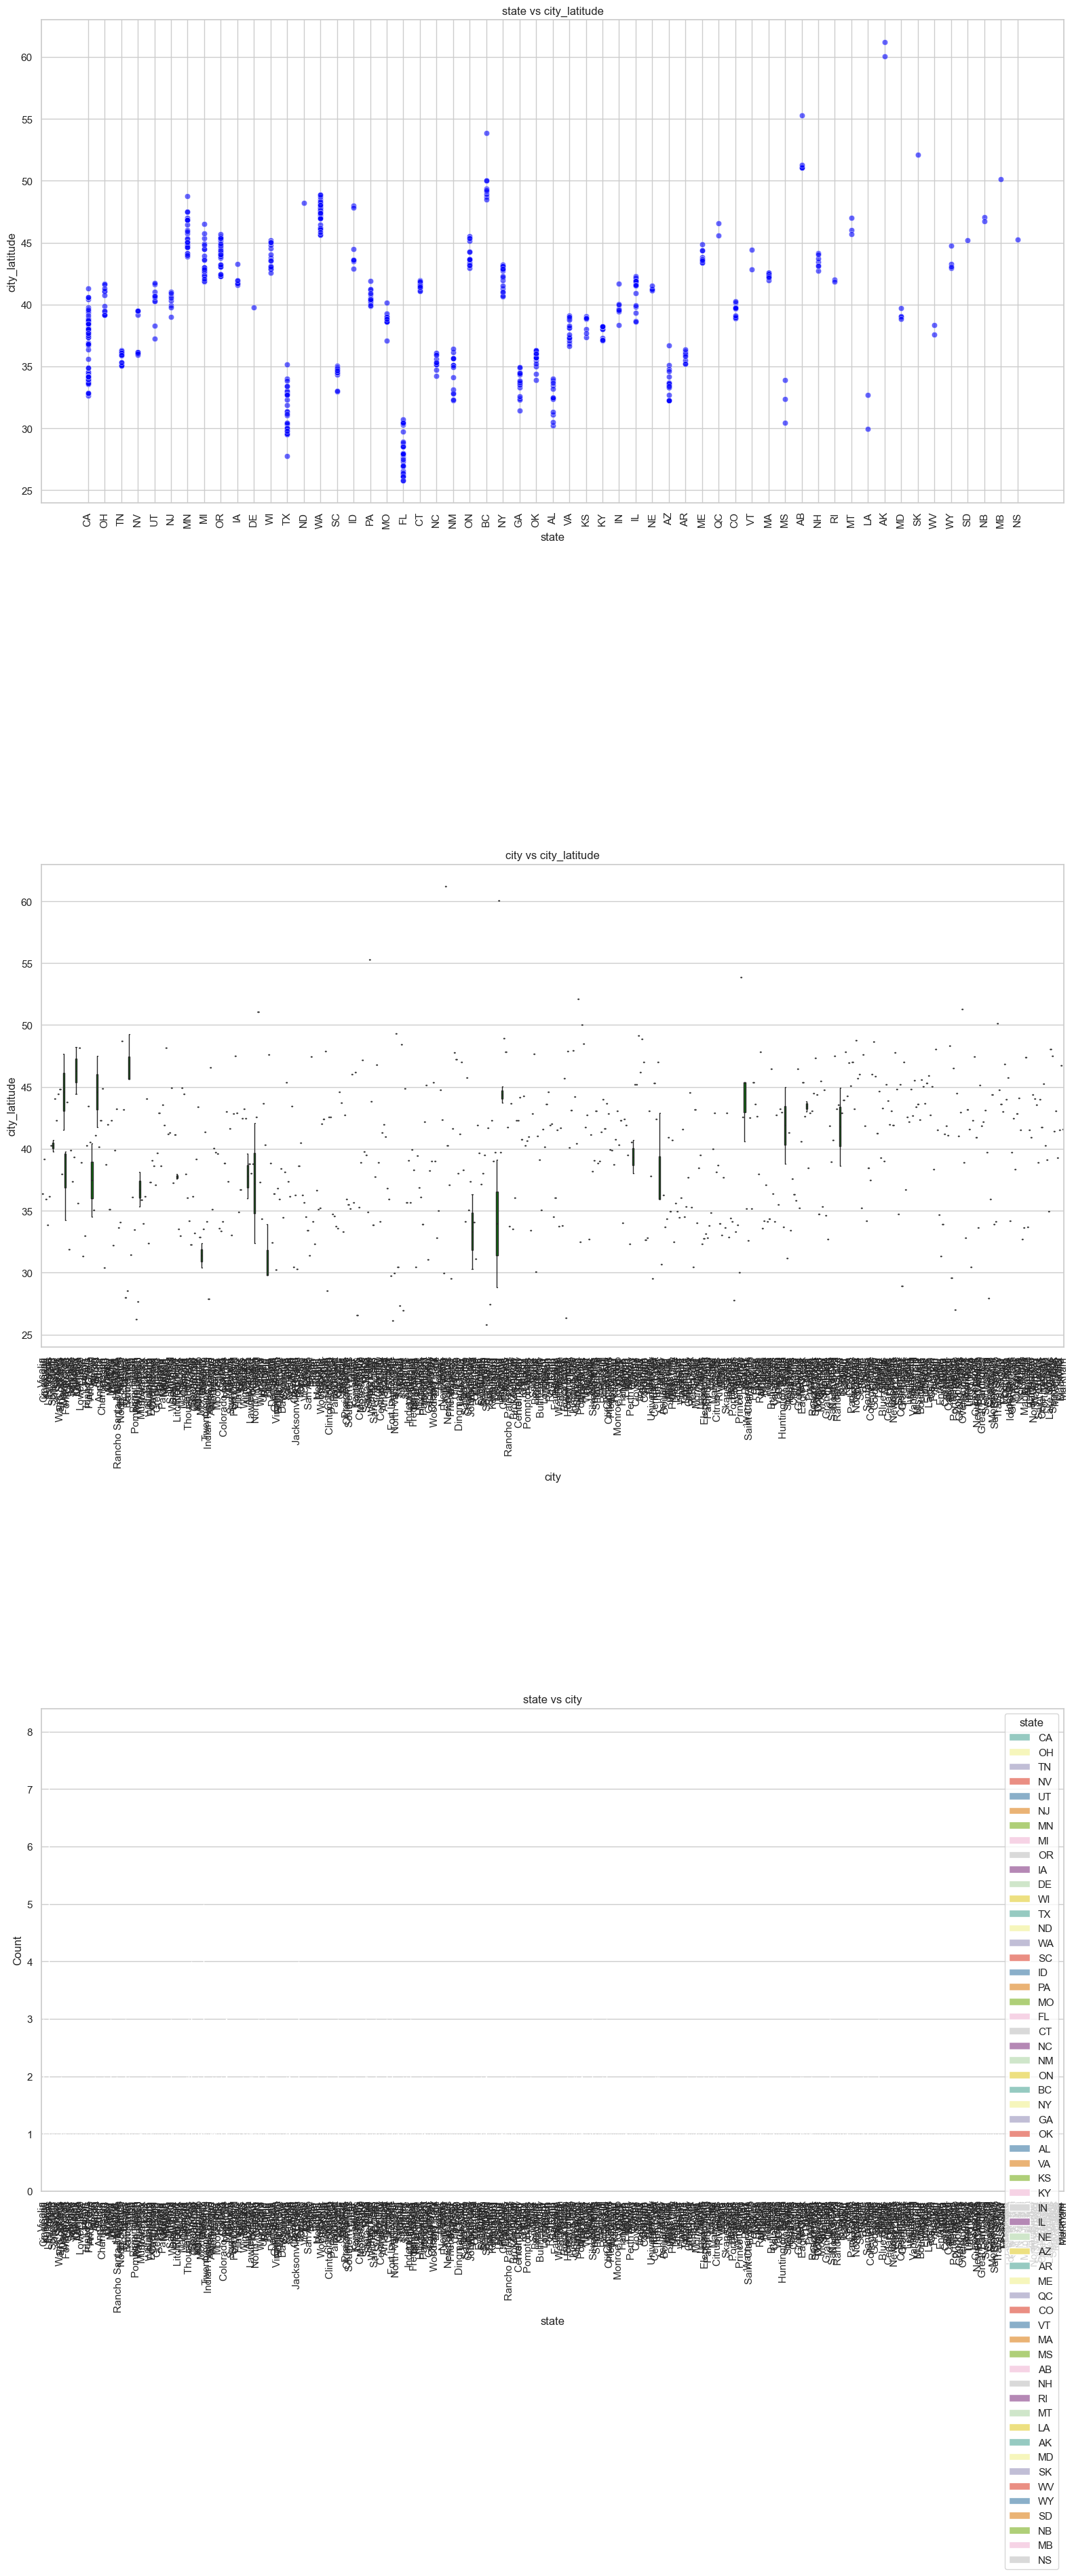

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Настройка стиля графиков
sns.set(style="whitegrid")

# Создание фигуры
plt.figure(figsize=(16, 45))

# График 1: Категория vs Цена
plt.subplot(4, 1, 1)
sns.scatterplot(x=df_cleaned['state'], y=df_cleaned['city_latitude'], alpha=0.6, color='blue')
plt.title('state vs city_latitude')
plt.xlabel('state')
plt.ylabel('city_latitude')
plt.xticks(rotation=90)

# График 2: Подкатегория vs Цена
plt.subplot(4, 1, 2)
sns.boxplot(x=df_cleaned['city'], y=df_cleaned['city_latitude'], color='green')
plt.title('city vs city_latitude')
plt.xlabel('city')
plt.ylabel('city_latitude')
plt.xticks(rotation=90)

# График 3: Категория vs Подкатегория
plt.subplot(4, 1, 3)
sns.countplot(x=df_cleaned['city'], hue=df_cleaned['state'], palette='Set3')
plt.title('state vs city')
plt.xlabel('state')
plt.ylabel('Count')
plt.xticks(rotation=90)

# Упорядочиваем графики
plt.tight_layout()
plt.show()

### Стандартизация данных для кластеризации

In [34]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pandas as pd

# Выделяем числовые и категориальные признаки
numerical_cols = ['city_latitude']
categorical_cols = ['state', 'city']

# Масштабирование числовых признаков
scaler = StandardScaler()
df_numerical_scaled = scaler.fit_transform(df_cleaned[numerical_cols])

# Кодирование категориальных признаков с помощью OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # sparse=False для удобства
encoded_data = encoder.fit_transform(df_cleaned[categorical_cols])

# Создаем новые столбцы для закодированных категориальных признаков
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols))

# Объединяем числовые и закодированные категориальные данные
df_encoded = pd.concat([pd.DataFrame(df_numerical_scaled, columns=numerical_cols), encoded_df], axis=1)

# Выводим результат
print(df_encoded.head())

   city_latitude  state_AB  state_AK  state_AL  state_AR  state_AZ  state_BC  \
0      -0.538951       0.0       0.0       0.0       0.0       0.0       0.0   
1      -0.031639       0.0       0.0       0.0       0.0       0.0       0.0   
2      -0.610081       0.0       0.0       0.0       0.0       0.0       0.0   
3      -0.985300       0.0       0.0       0.0       0.0       0.0       0.0   
4      -0.577732       0.0       0.0       0.0       0.0       0.0       0.0   

   state_CA  state_CO  state_CT  ...  city_Winchester  city_Winnsboro  \
0       1.0       0.0       0.0  ...              0.0             0.0   
1       0.0       0.0       0.0  ...              0.0             0.0   
2       0.0       0.0       0.0  ...              0.0             0.0   
3       1.0       0.0       0.0  ...              0.0             0.0   
4       0.0       0.0       0.0  ...              0.0             0.0   

   city_Winston  city_Woodburn  city_Woodland  city_Woodland Park  \
0          

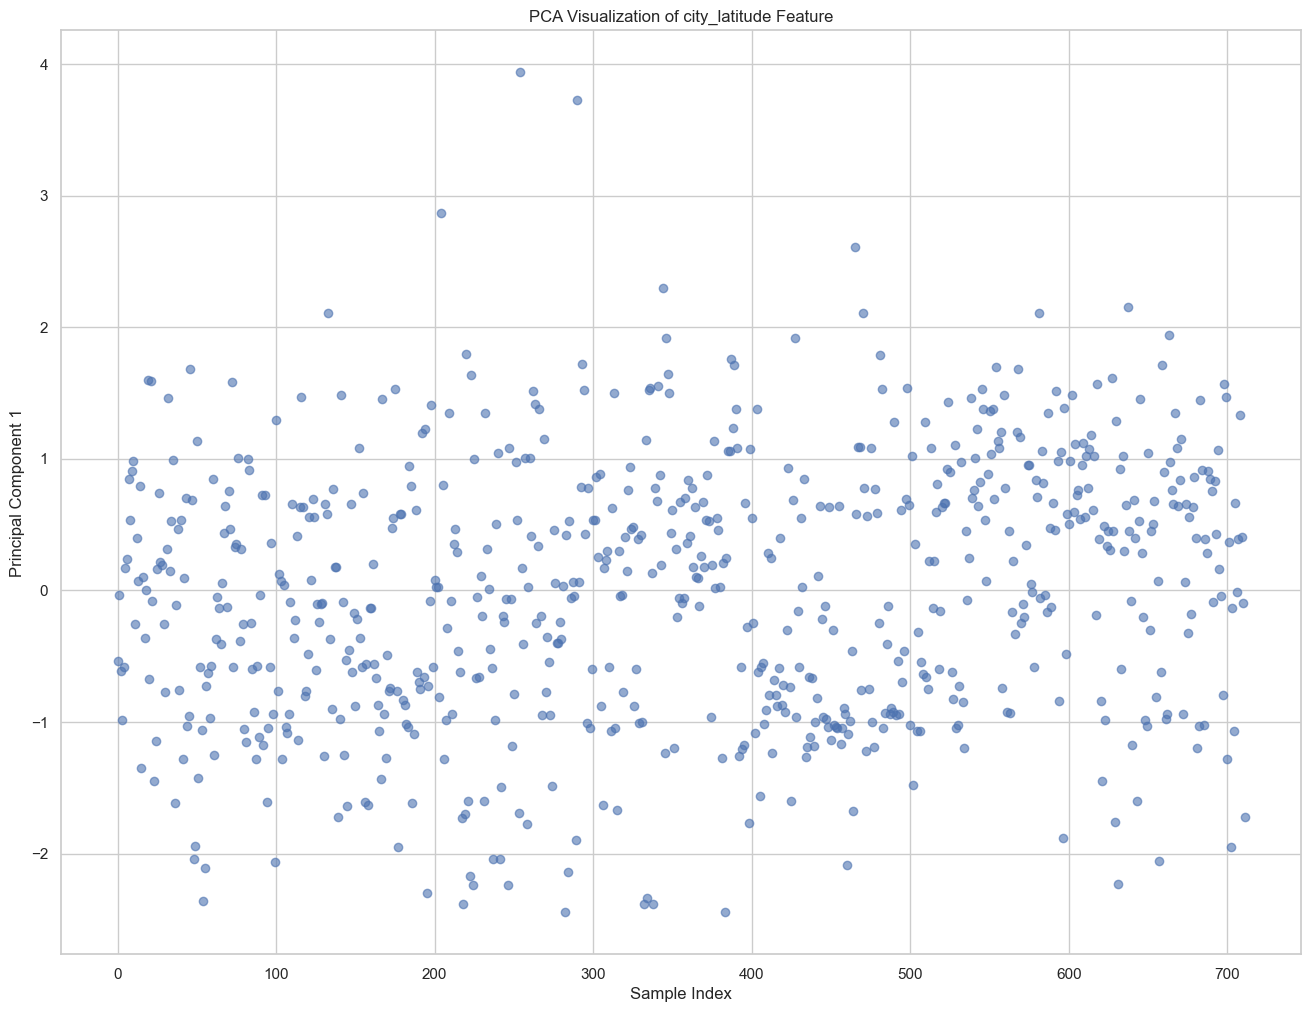

In [35]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Применение PCA ТОЛЬКО к числовым данным
pca = PCA(n_components=1)
kc_pca = pca.fit_transform(df_numerical_scaled)

# Визуализация
plt.figure(figsize=(16, 12))
plt.scatter(range(len(kc_pca)), kc_pca, alpha=0.6)
plt.title("PCA Visualization of city_latitude Feature")
plt.xlabel("Sample Index")
plt.ylabel("Principal Component 1")
plt.show()

### Агломеративная (иерархическая) кластеризация

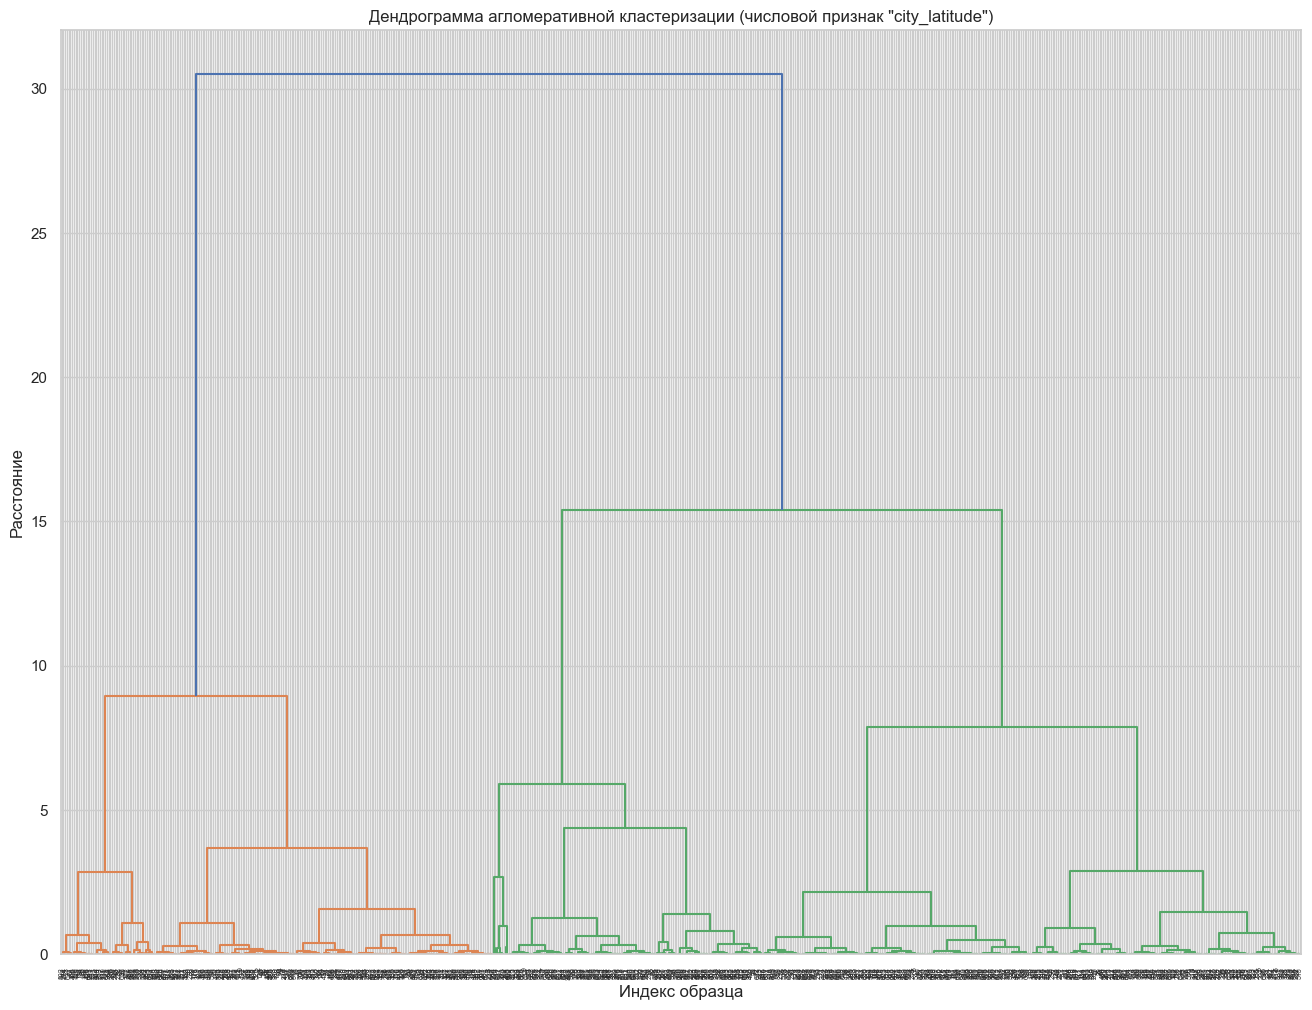

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [36]:
# Построение дендрограммы (только для числовых данных)
linkage_matrix = linkage(df_numerical_scaled, method='ward')

plt.figure(figsize=(16, 12))
dendrogram(linkage_matrix)
plt.title('Дендрограмма агломеративной кластеризации (числовой признак "city_latitude")')
plt.xlabel('Индекс образца')
plt.ylabel('Расстояние')
plt.show()

# Получение результатов кластеризации (только для числовых данных)
result = fcluster(linkage_matrix, t=100, criterion='distance') 
print(result)  # Вывод результатов кластеризации (номера кластеров для каждого образца)

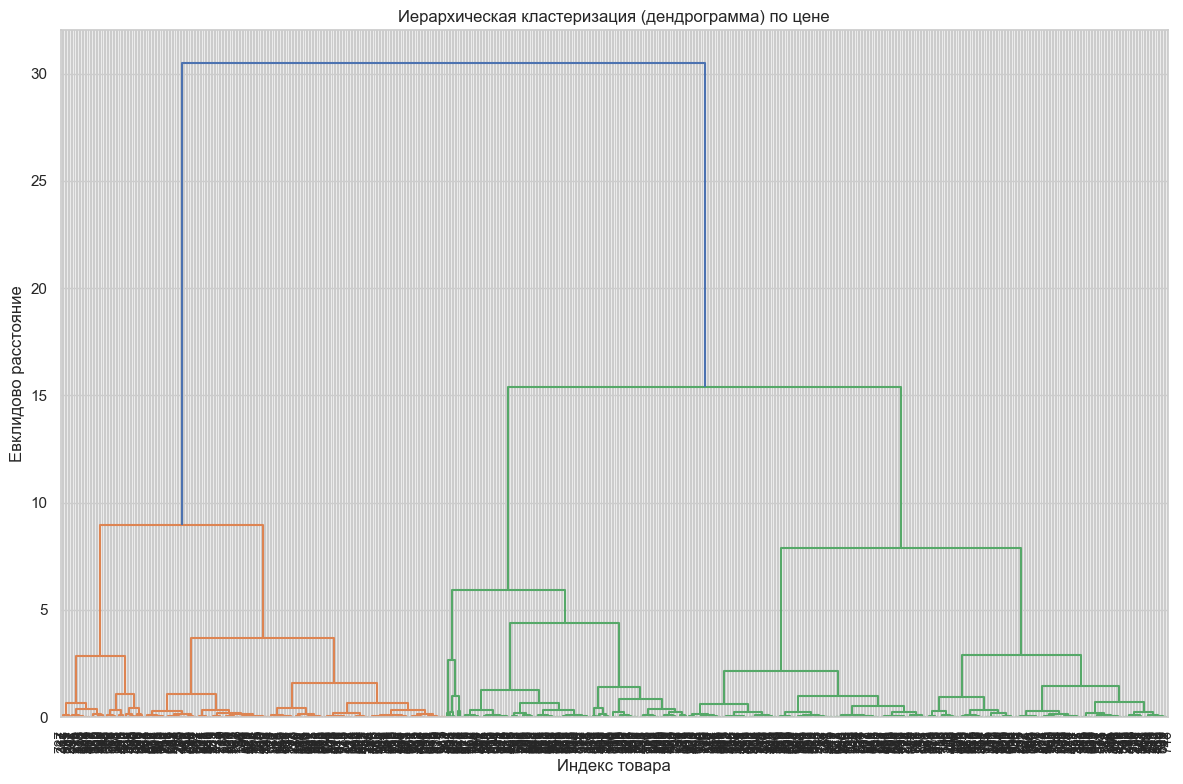

In [37]:
# Выбираем подмножество данных для кластеризации
features = df_encoded[['city_latitude']]

# Масштабирование числовых признаков
scaled_features = scaler.fit_transform(features)

# Построение дендрограммы
linkage_matrix = linkage(scaled_features, method='ward') 

plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, labels=df.index, leaf_rotation=90, leaf_font_size=10)
plt.title('Иерархическая кластеризация (дендрограмма) по цене')
plt.xlabel('Индекс товара')
plt.ylabel('Евклидово расстояние')
plt.tight_layout()
plt.show()

**Визуализация распределения кластеров**

C:\Users\Danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Danil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


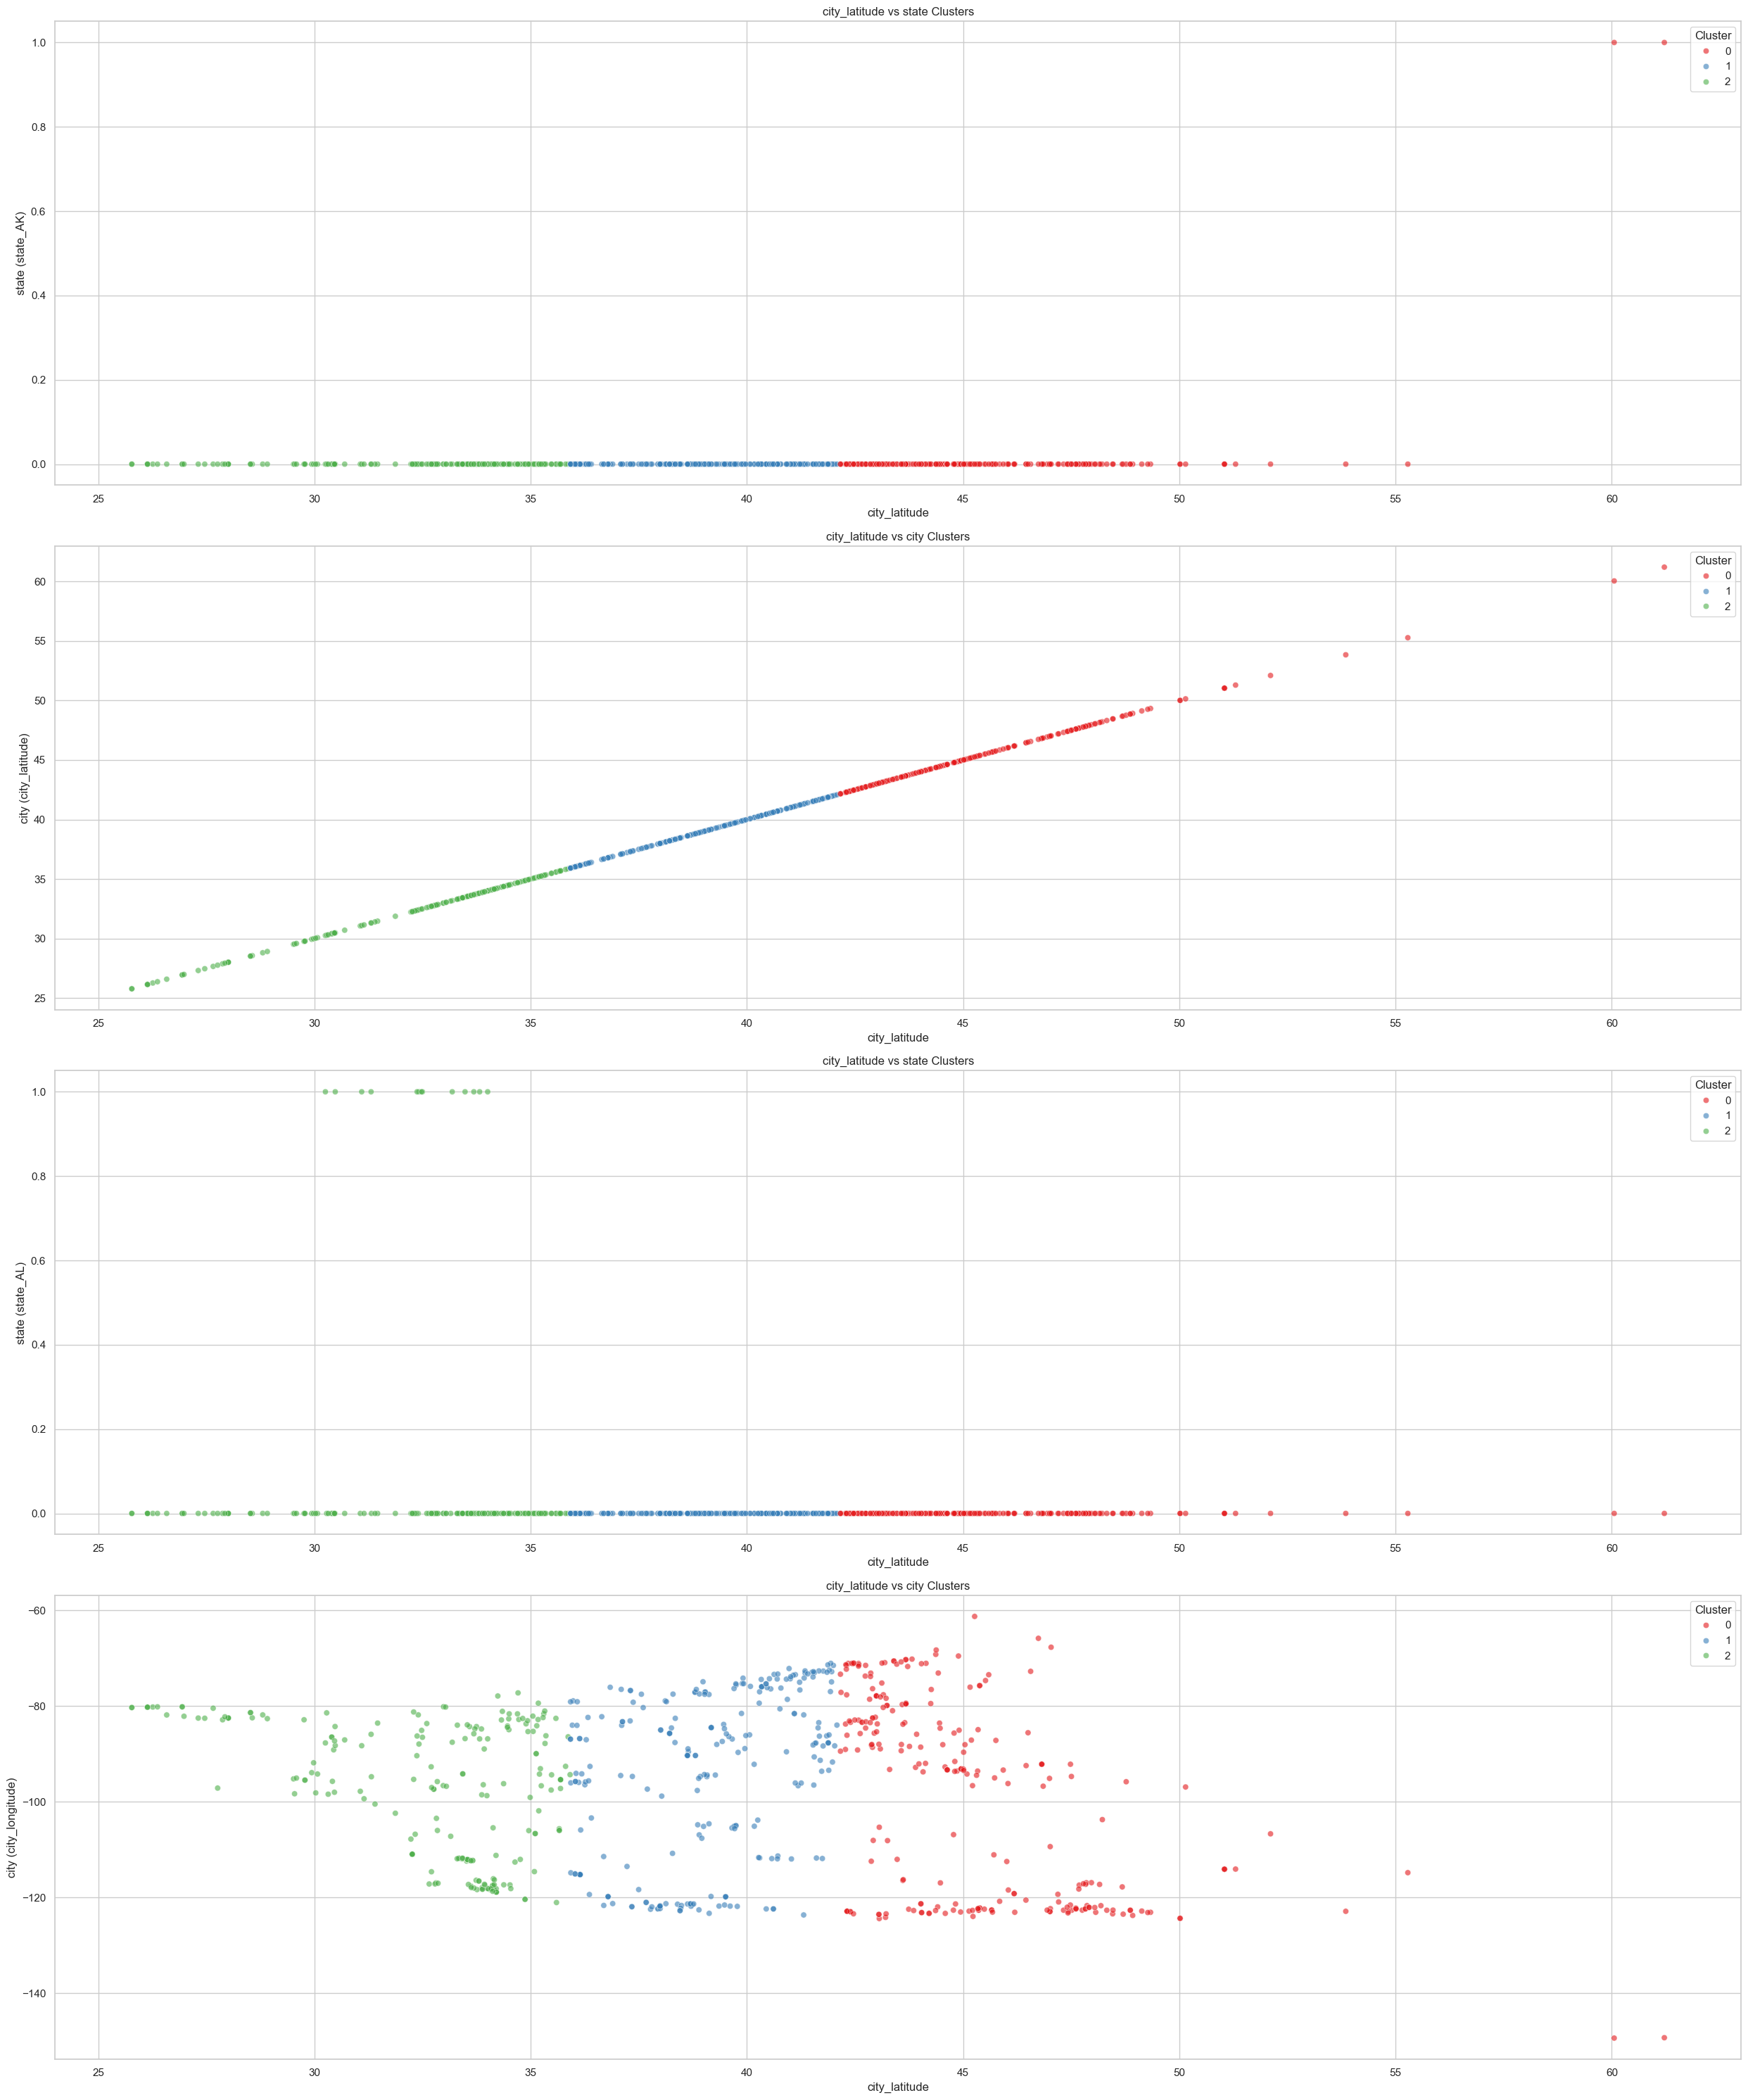

In [38]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Закодирование категориальных переменных
df_encoded = pd.get_dummies(df_cleaned, drop_first=True)

# Выбор подмножества данных для кластеризации
features = df_encoded[['city_latitude']]

# Масштабирование данных
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Кластеризация данных
kmeans = KMeans(n_clusters=3)
df_encoded['Cluster'] = kmeans.fit_predict(scaled_features)

# Визуализация кластеров
plt.figure(figsize=(25, 30))

# Парный график 1: city_latitude vs state
state_columns = [col for col in df_encoded.columns if col.startswith('state_')]
if state_columns:
    plt.subplot(4, 1, 1)
    sns.scatterplot(x=df_encoded['city_latitude'], y=df_encoded[state_columns[0]], hue=df_encoded['Cluster'], palette='Set1', alpha=0.6)
    plt.title('city_latitude vs state Clusters')
    plt.xlabel('city_latitude')
    plt.ylabel(f'state ({state_columns[0]})')
else:
    plt.subplot(4, 1, 1)
    plt.text(0.5, 0.5, 'No state columns found', ha='center', va='center', fontsize=12)
    plt.title('city_latitude vs state Clusters')

# Парный график 2: city_latitude vs city
city_columns = [col for col in df_encoded.columns if col.startswith('city_')]
if city_columns:
    plt.subplot(4, 1, 2)
    sns.scatterplot(x=df_encoded['city_latitude'], y=df_encoded[city_columns[0]], hue=df_encoded['Cluster'], palette='Set1', alpha=0.6)
    plt.title('city_latitude vs city Clusters')
    plt.xlabel('city_latitude')
    plt.ylabel(f'city ({city_columns[0]})')
else:
    plt.subplot(4, 1, 2)
    plt.text(0.5, 0.5, 'No city columns found', ha='center', va='center', fontsize=12)
    plt.title('city_latitude vs city Clusters')

# Парный график 3: city_latitude vs state (другая категория)
if len(state_columns) > 1:
    plt.subplot(4, 1, 3)
    sns.scatterplot(x=df_encoded['city_latitude'], y=df_encoded[state_columns[1]], hue=df_encoded['Cluster'], palette='Set1', alpha=0.6)
    plt.title('city_latitude vs state Clusters')
    plt.xlabel('city_latitude')
    plt.ylabel(f'state ({state_columns[1]})')
else:
    plt.subplot(4, 1, 3)
    plt.text(0.5, 0.5, 'Not enough state columns found', ha='center', va='center', fontsize=12)
    plt.title('city_latitude vs state Clusters')

# Парный график 4: city_latitude vs city (другая подкатегория)
if len(city_columns) > 1:
    plt.subplot(4, 1, 4)
    sns.scatterplot(x=df_encoded['city_latitude'], y=df_encoded[city_columns[1]], hue=df_encoded['Cluster'], palette='Set1', alpha=0.6)
    plt.title('city_latitude vs city Clusters')
    plt.xlabel('city_latitude')
    plt.ylabel(f'city ({city_columns[1]})')
else:
    plt.subplot(4, 1, 4)
    plt.text(0.5, 0.5, 'Not enough city columns found', ha='center', va='center', fontsize=12)
    plt.title('city_latitude vs city Clusters')

# Настройка графиков
plt.tight_layout()
plt.show()

## KMeans (неиерархическая кластеризация) для сравнения

Центры кластеров:
 [[48.25734972]
 [32.43819138]
 [37.9835445 ]
 [43.07246158]]


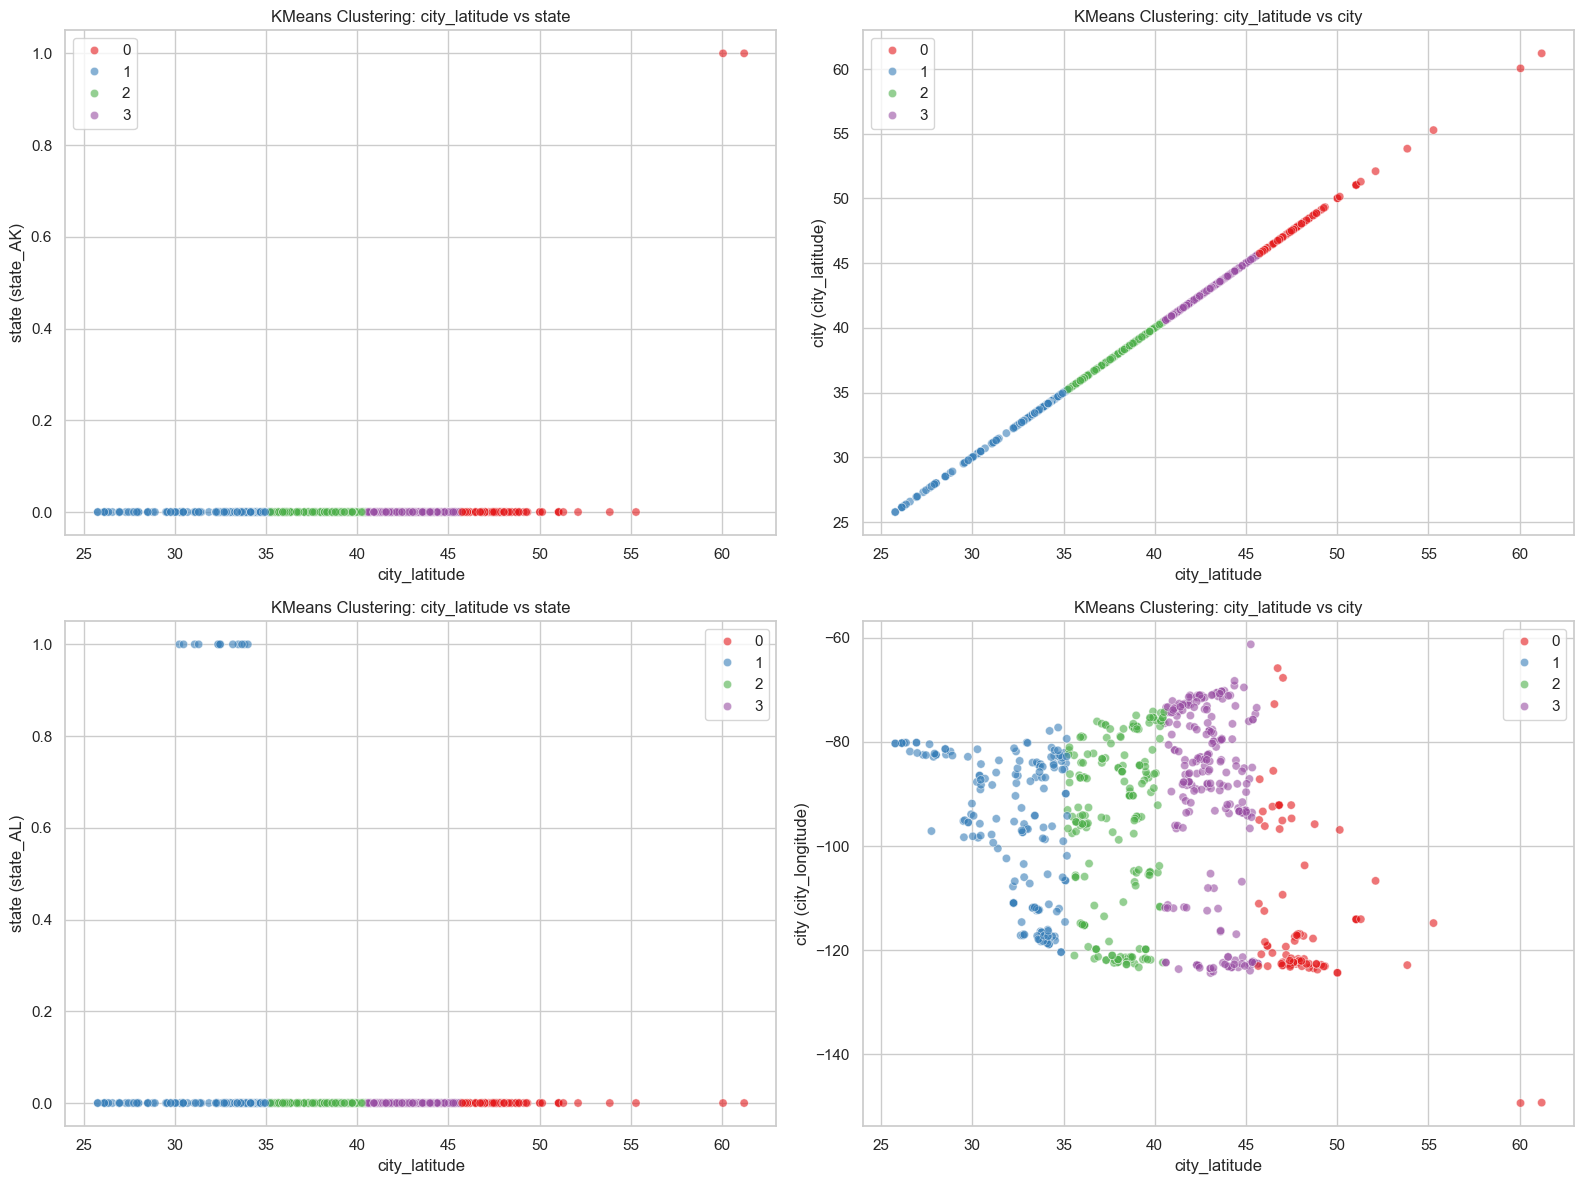

In [39]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Загрузка данных
df = pd.read_csv("../../datasets/nuforc_reports.csv")
df = df.iloc[:1000].dropna()

# Удаление несущественных столбцов
columns_to_drop = ['summary', 'stats', 'report_link', 'posted', "duration"]
df_cleaned = df.drop(columns=columns_to_drop)

# Закодирование категориальных переменных
df_encoded = pd.get_dummies(df_cleaned, drop_first=True)

# Выбор подмножества данных для кластеризации
features_used = ['city_latitude']
data_to_scale = df_encoded[features_used]

# Масштабирование данных
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_to_scale)

# Кластеризация данных
random_state = 42
kmeans = KMeans(n_clusters=4, random_state=random_state)
labels = kmeans.fit_predict(data_scaled)
centers = kmeans.cluster_centers_

# Отображение центроидов
centers_original = scaler.inverse_transform(centers)  # Обратная стандартизация
print("Центры кластеров:\n", centers_original)

# Визуализация результатов кластеризации KMeans
plt.figure(figsize=(16, 12))

# Парный график 1: city_latitude vs state
plt.subplot(2, 2, 1)
state_columns = [col for col in df_encoded.columns if col.startswith('state_')]
if state_columns:
    sns.scatterplot(x=df_cleaned['city_latitude'], y=df_encoded[state_columns[0]], hue=labels, palette='Set1', alpha=0.6)
    plt.title('KMeans Clustering: city_latitude vs state')
    plt.xlabel('city_latitude')
    plt.ylabel(f'state ({state_columns[0]})')
else:
    plt.title('KMeans Clustering: city_latitude vs state (No Data)')
    plt.xlabel('city_latitude')
    plt.ylabel('state')

# Парный график 2: city_latitude vs city
plt.subplot(2, 2, 2)
city_columns = [col for col in df_encoded.columns if col.startswith('city_')]
if city_columns:
    sns.scatterplot(x=df_cleaned['city_latitude'], y=df_encoded[city_columns[0]], hue=labels, palette='Set1', alpha=0.6)
    plt.title('KMeans Clustering: city_latitude vs city')
    plt.xlabel('city_latitude')
    plt.ylabel(f'city ({city_columns[0]})')
else:
    plt.title('KMeans Clustering: city_latitude vs city (No Data)')
    plt.xlabel('city_latitude')
    plt.ylabel('city')

# Парный график 3: city_latitude vs state (другая категория)
plt.subplot(2, 2, 3)
if len(state_columns) > 1:
    sns.scatterplot(x=df_cleaned['city_latitude'], y=df_encoded[state_columns[1]], hue=labels, palette='Set1', alpha=0.6)
    plt.title('KMeans Clustering: city_latitude vs state')
    plt.xlabel('city_latitude')
    plt.ylabel(f'state ({state_columns[1]})')
else:
    plt.title('KMeans Clustering: city_latitude vs state (No Data)')
    plt.xlabel('city_latitude')
    plt.ylabel('state')

# Парный график 4: city_latitude vs city (другая подкатегория)
plt.subplot(2, 2, 4)
if len(city_columns) > 1:
    sns.scatterplot(x=df_cleaned['city_latitude'], y=df_encoded[city_columns[1]], hue=labels, palette='Set1', alpha=0.6)
    plt.title('KMeans Clustering: city_latitude vs city')
    plt.xlabel('city_latitude')
    plt.ylabel(f'city ({city_columns[1]})')
else:
    plt.title('KMeans Clustering: city_latitude vs city (No Data)')
    plt.xlabel('city_latitude')
    plt.ylabel('city')

# Настройка графиков
plt.tight_layout()
plt.show()

### PCA для визуализации сокращенной размерности

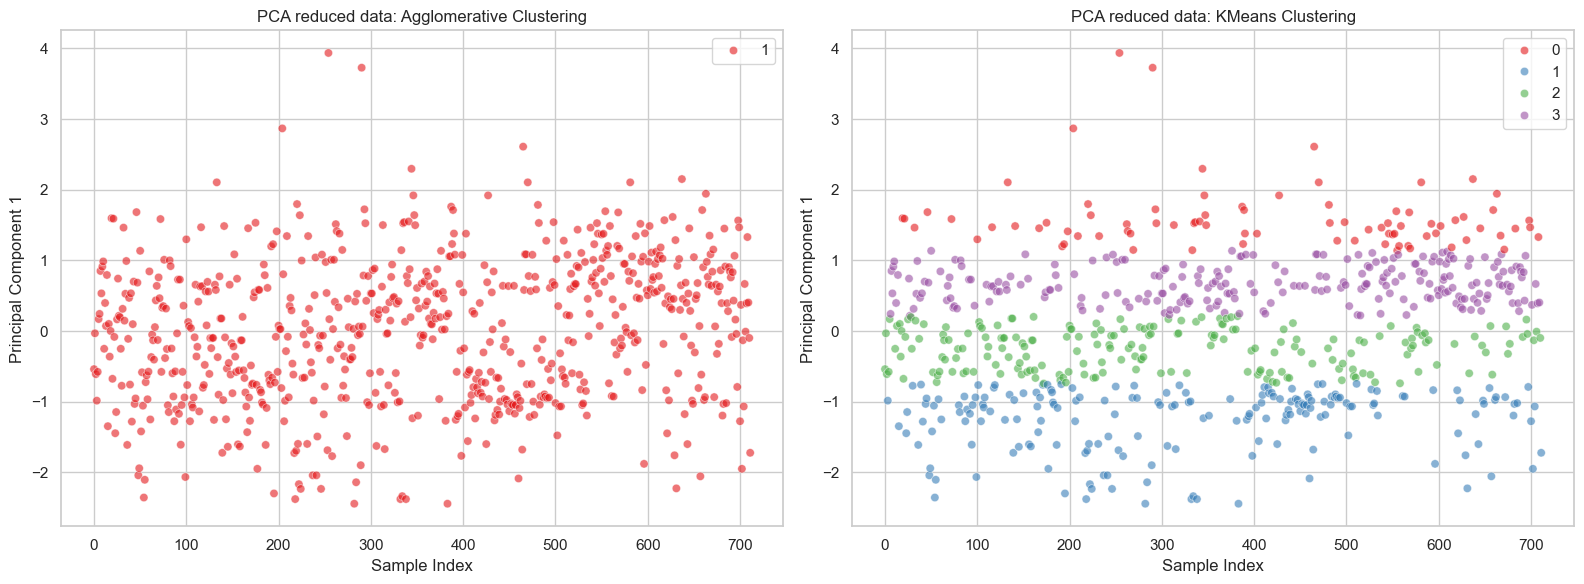

In [40]:
# Применение PCA ТОЛЬКО к числовым данным
pca = PCA(n_components=1)
reduced_data = pca.fit_transform(data_scaled)

# Визуализация сокращенных данных
plt.figure(figsize=(16, 6))

# График 1: PCA reduced data: Agglomerative Clustering
plt.subplot(1, 2, 1)
sns.scatterplot(x=range(len(reduced_data)), y=reduced_data[:, 0], hue=result, palette='Set1', alpha=0.6)
plt.title('PCA reduced data: Agglomerative Clustering')
plt.xlabel('Sample Index')
plt.ylabel('Principal Component 1')

# График 2: PCA reduced data: KMeans Clustering
plt.subplot(1, 2, 2)
sns.scatterplot(x=range(len(reduced_data)), y=reduced_data[:, 0], hue=labels, palette='Set1', alpha=0.6)
plt.title('PCA reduced data: KMeans Clustering')
plt.xlabel('Sample Index')
plt.ylabel('Principal Component 1')

plt.tight_layout()
plt.show()

### Анализ инерции для метода локтя (метод оценки суммы квадратов расстояний)

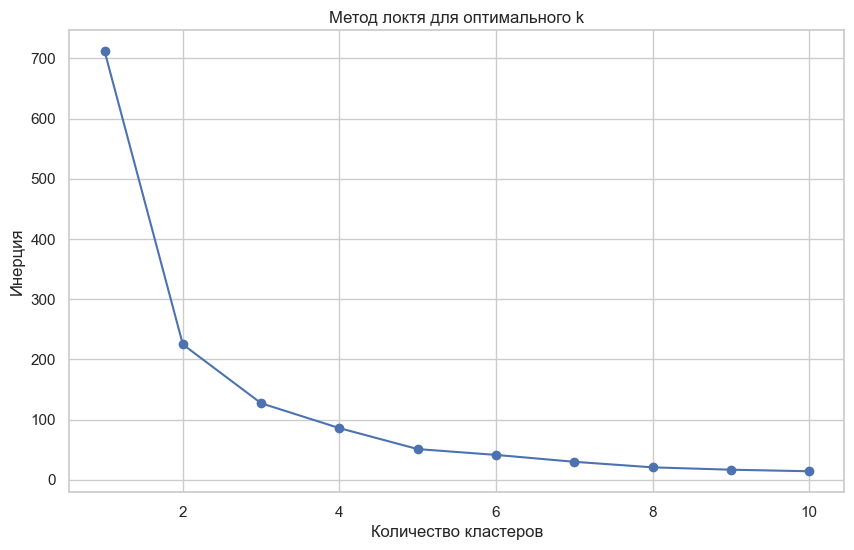

In [41]:
# Список для хранения инерций
inertias = []
clusters_range = range(1, 11)

# Вычисление инерции для каждого количества кластеров
for i in clusters_range:
    kmeans = KMeans(n_clusters=i, random_state=random_state)
    kmeans.fit(data_scaled)
    inertias.append(kmeans.inertia_)

# Визуализация метода локтя
plt.figure(figsize=(10, 6))
plt.plot(clusters_range, inertias, marker='o')
plt.title('Метод локтя для оптимального k')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.grid(True)
plt.show()

### Расчет коэффициентов силуэта

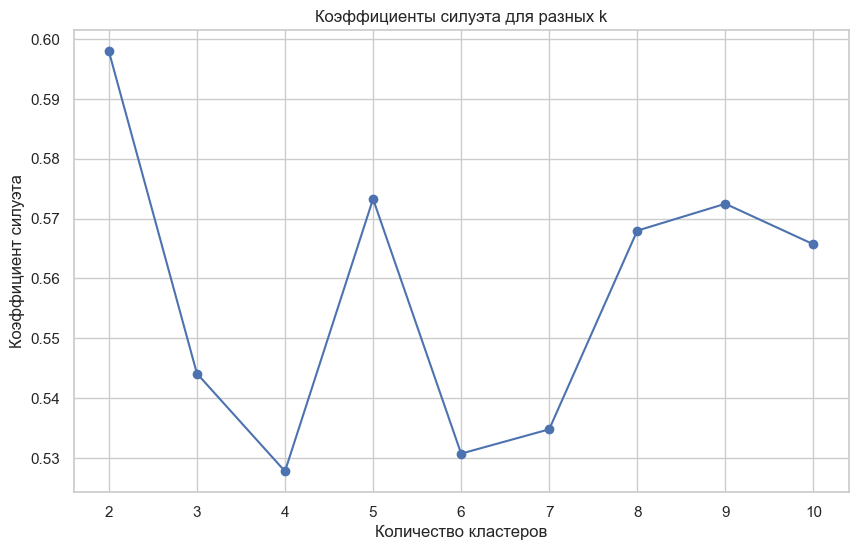

In [42]:
# Список для хранения коэффициентов силуэта
silhouette_scores = []

# Вычисление коэффициентов силуэта для каждого количества кластеров
for i in clusters_range[1:]:  
    kmeans = KMeans(n_clusters=i, random_state=random_state)
    labels = kmeans.fit_predict(data_scaled)
    score = silhouette_score(data_scaled, labels)
    silhouette_scores.append(score)

# Построение диаграммы значений силуэта
plt.figure(figsize=(10, 6))
plt.plot(clusters_range[1:], silhouette_scores, marker='o')
plt.title('Коэффициенты силуэта для разных k')
plt.xlabel('Количество кластеров')
plt.ylabel('Коэффициент силуэта')
plt.grid(True)
plt.show()

Средний коэффициент силуэта: 0.544


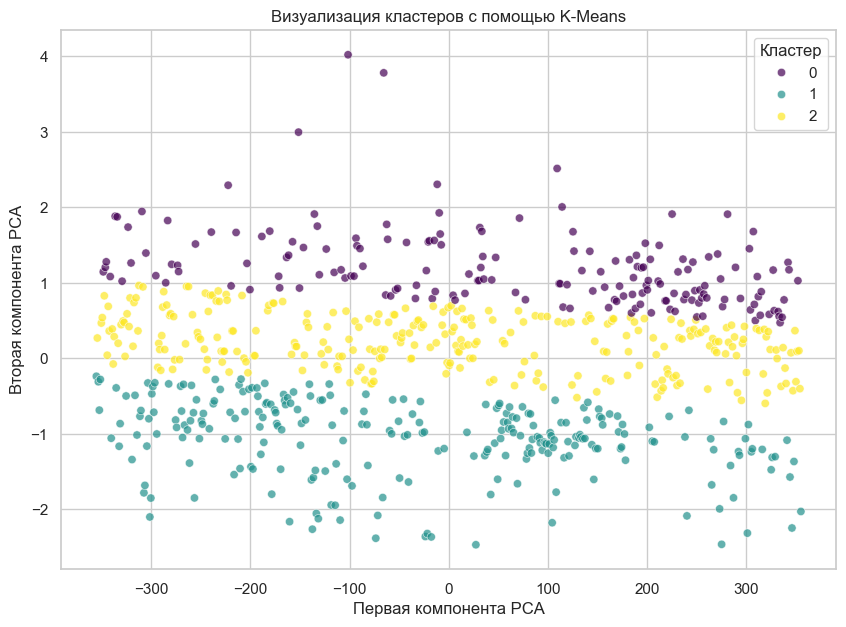

In [43]:
# Добавляем индекс строки как дополнительный признак
data_scaled_with_index = np.hstack((data_scaled, np.arange(data_scaled.shape[0]).reshape(-1, 1)))

# ========================
# Применение K-Means
# ========================
kmeans = KMeans(n_clusters=3, random_state=42)  
df_clusters = kmeans.fit_predict(data_scaled)

# ========================
# Оценка качества кластеризации
# ========================
silhouette_avg = silhouette_score(data_scaled, df_clusters)
print(f'Средний коэффициент силуэта: {silhouette_avg:.3f}')

# ========================
# Визуализация кластеров
# ========================
pca = PCA(n_components=2)
df_pca = pca.fit_transform(data_scaled_with_index)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=df_clusters, palette='viridis', alpha=0.7)
plt.title('Визуализация кластеров с помощью K-Means')
plt.xlabel('Первая компонента PCA')
plt.ylabel('Вторая компонента PCA')
plt.legend(title='Кластер', loc='upper right')
plt.show()

Средний коэффициент силуэта, равный 0.544, указывает на хорошую кластеризацию.  

Средний коэффициент силуэта (silhouette score) указывает на качество кластеризации, измеряя, насколько хорошо точки внутри одного кластера близки друг к другу по сравнению с точками из других кластеров. Значения коэффициента силуэта находятся в диапазоне от -1 до 1:

1: Указывает на идеально плотные и четко разделенные кластеры.  
0: Указывает на перекрытие кластеров или слабую структуру кластеризации.  
Отрицательные значения: Указывают, что точки в кластере расположены ближе к другому кластеру, чем к своему.

Средний коэффициент силуэта (агломеративная кластеризация): 0.542


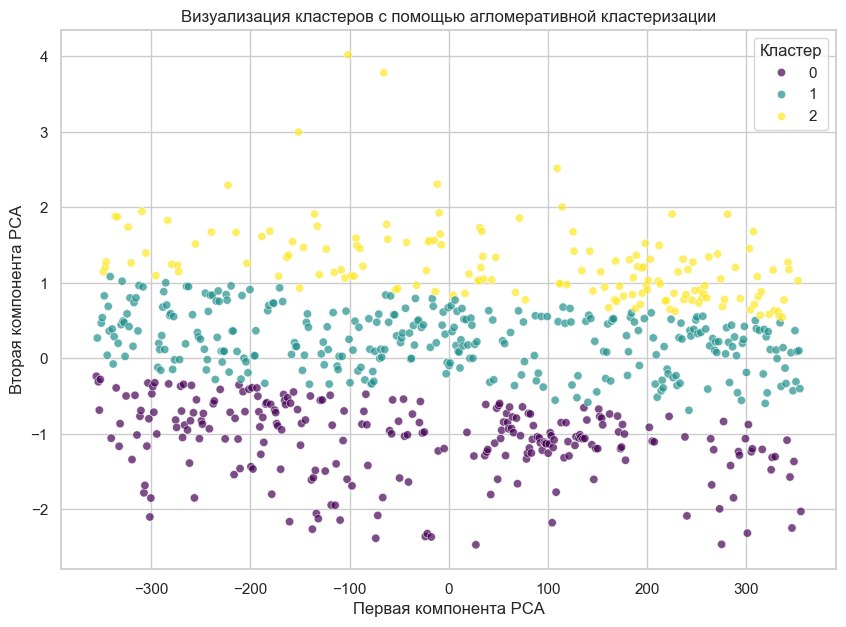

In [45]:
from sklearn.cluster import AgglomerativeClustering

# Добавляем индекс строки как дополнительный признак
data_scaled_with_index = np.hstack((data_scaled, np.arange(data_scaled.shape[0]).reshape(-1, 1)))

# ========================
# Агломеративная кластеризация
# ========================
agg_cluster = AgglomerativeClustering(n_clusters=3)  
labels_agg = agg_cluster.fit_predict(data_scaled)

# ========================
# Оценка качества кластеризации
# ========================
silhouette_avg_agg = silhouette_score(data_scaled, labels_agg)
print(f'Средний коэффициент силуэта (агломеративная кластеризация): {silhouette_avg_agg:.3f}')

# ========================
# Визуализация кластеров
# ========================
pca = PCA(n_components=2)
df_pca = pca.fit_transform(data_scaled_with_index)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=labels_agg, palette='viridis', alpha=0.7)
plt.title('Визуализация кластеров с помощью агломеративной кластеризации')
plt.xlabel('Первая компонента PCA')
plt.ylabel('Вторая компонента PCA')
plt.legend(title='Кластер', loc='upper right')
plt.show()

Значение коэффициента силуэта лежит в диапазоне от -1 до 1. Ближе к 1: Хорошо сформированные, плотные кластеры, четко отделенные друг от друга.  

Ближе к 0: Кластеры пересекаются или слабо разделены, не имеют четких границ. Точки расположены одинаково близко как к своему кластеру, так и к соседним. 
Ближе к -1 (Отрицательные значения): Некоторые точки скорее относятся к другим кластерам, чем к текущему (ближе к центрам других кластеров). Очень плохая кластеризация.  
Ближе к 1: Все точки внутри каждого кластера плотно сгруппированы и значительно удалены от точек других кластеров. Свидетельствует о четкой и хорошо разделенной структуре данных. Единица говорит об идеальной кластеризации.

Средний коэффициент силуэта, равный 0.542, указывает на то, что кластеры имеют хорошее разделение и четкие границы. Точки внутри каждого кластера достаточно плотно сгруппированы и значительно удалены от точек других кластеров, что свидетельствует о четкой и хорошо разделенной структуре данных.